In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cities = np.genfromtxt('csv/Argentina.csv', delimiter=',')
cities = cities[1:, 1:]
n_cities = cities.shape[0]
cities

array([[36266.6667, 62550.    ],
       [34600.    , 58633.3333],
       [51650.    , 72300.    ],
       ...,
       [34878.0556, 58135.8333],
       [34917.2222, 58386.9444],
       [34976.9444, 58686.9444]])

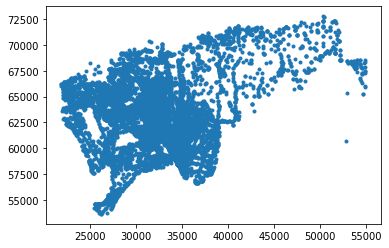

In [3]:
plt.scatter(cities[:, 0], cities[:, 1], marker='.')

In [4]:
def d(i, j):
    return np.linalg.norm(cities[i, :] - cities[j, :])

In [5]:
d(0, 1)

4256.53097343104

In [6]:
class Individual:
    def __init__(self, gnome):
        self.gnome = gnome
        self.fitness = self.calculate_fitness(gnome)
        
    # Muta al individuo
    def mutate(self):
        gnome = np.copy(self.gnome)
        i, j = np.random.choice(len(gnome), size=2, replace=False)
        gnome[i], gnome[j] = gnome[j], gnome[i]
        return Individual(gnome)
    
    # Two point crossover
    def cross(self, q):
        child = np.copy(self.gnome)
        start, end = np.sort(np.random.choice(len(child), size=2, replace=False))
        child[:start] = child[end+1:] = -1
        child[child == -1] = np.setdiff1d(q.gnome, child, assume_unique = True)
        return Individual(child)
        
    def calculate_fitness(cls, gnome):
        return sum([d(gnome[i], gnome[i+1]) for i in range(0, len(gnome) - 1)]) + d(gnome[len(gnome) - 1], gnome[0])

In [7]:
i = Individual(np.array([0, 5, 10, 15]))
i.fitness

20607.95743028738

In [8]:
o = i.mutate()
o.gnome, i.gnome

(array([ 0, 10,  5, 15]), array([ 0,  5, 10, 15]))

In [9]:
a = Individual(np.array([1, 2, 3, 4, 5]))
b = Individual(np.array([2, 1, 3, 5, 4]))
c = a.cross(b)
a.gnome, b.gnome, c.gnome

(array([1, 2, 3, 4, 5]), array([2, 1, 3, 5, 4]), array([2, 1, 3, 4, 5]))

In [10]:
def GA(n_population = 20, n_generation = 100, cross_rate = 0.5, mutate_rate = 0.2):
    # Para la generación 0
    Pk = random_population(n_population)
    # best_individual = Pk.best
    for k in range(1, n_generation):
        # Creamos la siguiente generacion
        pass